In [143]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

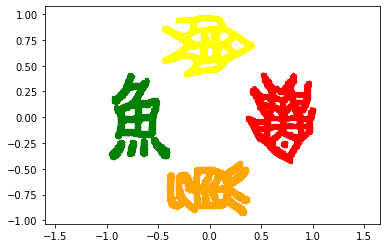

In [129]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.2, -1], center = [-.07, .7], rotate = -np.pi/2),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:18,  1.67s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.6699 | Iter: 1.6686 | fit: 0.2464 | reg: 0.1671 | save: 0.0000) | autograd: 1.2527]


 17%|█▋        | 51/300 [01:43<19:00,  4.58s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1920 | lr: 0.0001 | n_subsample: 378] 
[Total time : 103.9631 | Iter: 93.7369 | fit: 0.3000 | reg: 0.2471 | save: 8.5544) | autograd: 1.4761]


 34%|███▎      | 101/300 [03:34<15:39,  4.72s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1101 | lr: 0.0001 | n_subsample: 476] 
[Total time : 214.0755 | Iter: 101.5491 | fit: 0.2889 | reg: 0.3074 | save: 8.5499) | autograd: 1.6385]


 50%|█████     | 151/300 [05:26<11:23,  4.59s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1075 | lr: 0.0001 | n_subsample: 600] 
[Total time : 326.8526 | Iter: 104.3059 | fit: 0.3084 | reg: 0.2223 | save: 8.4693) | autograd: 1.3802]


 67%|██████▋   | 201/300 [07:19<07:31,  4.56s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1214 | lr: 5e-05 | n_subsample: 756] 
[Total time : 439.0355 | Iter: 103.9125 | fit: 0.3310 | reg: 0.2352 | save: 8.2688) | autograd: 1.4705]


 84%|████████▎ | 251/300 [09:13<03:42,  4.54s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.0705 | lr: 5e-05 | n_subsample: 953] 
[Total time : 553.5966 | Iter: 106.6982 | fit: 0.3403 | reg: 0.2791 | save: 7.8617) | autograd: 1.6063]


100%|██████████| 300/300 [11:08<00:00,  2.23s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.0553 | lr: 5e-05 | n_subsample: 953] 
[Total time : 668.6479 | Iter: 107.2663 | fit: 0.3158 | reg: 0.2857 | save: 7.7836) | autograd: 1.6296]


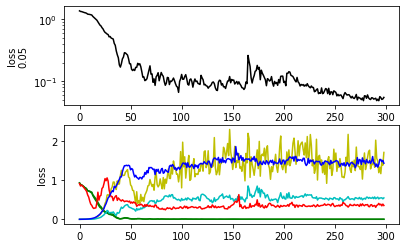

In [136]:
## TRAIN FISH1234 circle. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [137]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<09:00,  1.81s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 2.3989 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.8076 | Iter: 1.8064 | fit: 0.2590 | reg: 0.2130 | save: 0.0000) | autograd: 1.3321]


 17%|█▋        | 51/300 [01:46<18:44,  4.51s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 0.8006 | lr: 0.0001 | n_subsample: 378] 
[Total time : 106.3072 | Iter: 96.6790 | fit: 0.3306 | reg: 0.2776 | save: 7.8193) | autograd: 1.7080]


 34%|███▎      | 101/300 [03:46<15:01,  4.53s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 0.6401 | lr: 0.0001 | n_subsample: 476] 
[Total time : 226.8920 | Iter: 112.9934 | fit: 0.3582 | reg: 0.2914 | save: 7.5895) | autograd: 1.5737]


 50%|█████     | 151/300 [05:51<11:41,  4.71s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 0.6527 | lr: 0.0001 | n_subsample: 600] 
[Total time : 351.3223 | Iter: 116.7848 | fit: 0.3724 | reg: 0.2859 | save: 7.6436) | autograd: 1.7730]


 67%|██████▋   | 201/300 [07:58<07:35,  4.60s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 0.5861 | lr: 5e-05 | n_subsample: 756] 
[Total time : 478.9216 | Iter: 120.0424 | fit: 0.3459 | reg: 0.2440 | save: 7.5554) | autograd: 1.5576]


 84%|████████▎ | 251/300 [10:09<03:50,  4.70s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 0.5662 | lr: 5e-05 | n_subsample: 953] 
[Total time : 609.1384 | Iter: 122.7650 | fit: 0.3898 | reg: 0.2977 | save: 7.4498) | autograd: 1.7622]


100%|██████████| 300/300 [12:15<00:00,  2.45s/it]

Allocated: 0.58 GB  Reserved: 1.19 GB
[Loss: 0.5186 | lr: 5e-05 | n_subsample: 953] 
[Total time : 735.6749 | Iter: 118.8065 | fit: 0.3857 | reg: 0.3066 | save: 7.7280) | autograd: 1.6997]


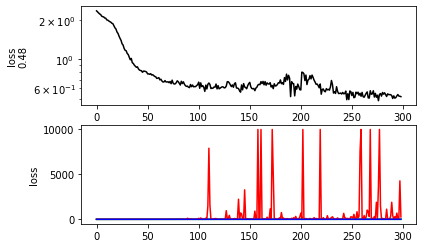

In [132]:
## TRAIN FISH1234 circle. Jerk=.01. rigid=.1, curl-pi=.1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [145]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True, lw=2)

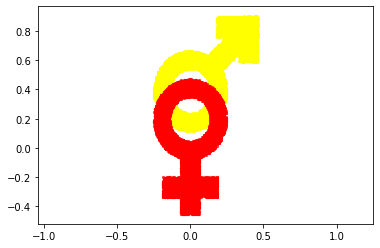

In [72]:
## GENERATE MF IMAGES
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.1, .5], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

In [75]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF2_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:09,  1.58it/s]

Allocated: 0.04 GB  Reserved: 1.03 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6351 | Iter: 0.6342 | fit: 0.1119 | reg: 0.0890 | save: 0.0000) | autograd: 0.4308]


 17%|█▋        | 51/300 [00:37<07:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1390 | lr: 0.0001 | n_subsample: 378] 
[Total time : 37.4436 | Iter: 33.1441 | fit: 0.0998 | reg: 0.0897 | save: 3.6630) | autograd: 0.5577]


 34%|███▎      | 101/300 [01:15<06:03,  1.83s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1245 | lr: 0.0001 | n_subsample: 476] 
[Total time : 75.2739 | Iter: 34.0856 | fit: 0.1107 | reg: 0.0971 | save: 3.7426) | autograd: 0.5434]


 50%|█████     | 151/300 [01:52<04:31,  1.82s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1156 | lr: 0.0001 | n_subsample: 600] 
[Total time : 112.8752 | Iter: 33.7381 | fit: 0.0944 | reg: 0.0814 | save: 3.8616) | autograd: 0.5019]


 67%|██████▋   | 201/300 [02:30<03:07,  1.89s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1259 | lr: 0.0001 | n_subsample: 756] 
[Total time : 150.5676 | Iter: 33.7116 | fit: 0.0999 | reg: 0.0975 | save: 3.9791) | autograd: 0.5305]


 84%|████████▎ | 251/300 [03:08<01:30,  1.86s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1135 | lr: 5e-05 | n_subsample: 953] 
[Total time : 188.3963 | Iter: 33.8876 | fit: 0.0847 | reg: 0.0793 | save: 3.9390) | autograd: 0.4525]


 89%|████████▊ | 266/300 [03:18<00:25,  1.34it/s]


KeyboardInterrupt: 

In [74]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF2_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

  0%|          | 1/300 [00:00<03:04,  1.62it/s]

Allocated: 0.04 GB  Reserved: 1.03 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6200 | Iter: 0.6191 | fit: 0.0922 | reg: 0.0759 | save: 0.0000) | autograd: 0.4474]


 17%|█▋        | 51/300 [00:37<07:46,  1.87s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1831 | lr: 0.0001 | n_subsample: 378] 
[Total time : 37.4737 | Iter: 32.8240 | fit: 0.0935 | reg: 0.0831 | save: 4.0279) | autograd: 0.4340]


 34%|███▎      | 101/300 [01:15<06:07,  1.85s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1172 | lr: 0.0001 | n_subsample: 476] 
[Total time : 75.4136 | Iter: 34.0470 | fit: 0.0942 | reg: 0.0915 | save: 3.8900) | autograd: 0.4968]


 50%|█████     | 151/300 [01:53<04:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1040 | lr: 0.0001 | n_subsample: 600] 
[Total time : 113.0945 | Iter: 33.9536 | fit: 0.0892 | reg: 0.0810 | save: 3.7249) | autograd: 0.4552]


 67%|██████▋   | 201/300 [02:30<03:06,  1.88s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1136 | lr: 5e-05 | n_subsample: 756] 
[Total time : 150.9560 | Iter: 33.8102 | fit: 0.1070 | reg: 0.0902 | save: 4.0488) | autograd: 0.4604]


 79%|███████▉  | 238/300 [02:57<00:46,  1.34it/s]


KeyboardInterrupt: 

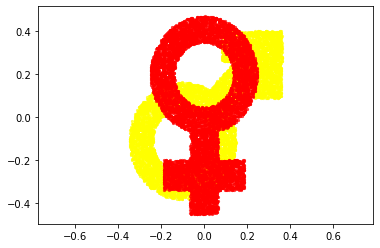

In [60]:
## GENERATE MF IMAGES
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:27,  1.44it/s]

Allocated: 0.04 GB  Reserved: 1.02 GB
[Loss: 1.4143 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6952 | Iter: 0.6937 | fit: 0.0843 | reg: 0.0767 | save: 0.0000) | autograd: 0.5310]


 17%|█▋        | 51/300 [00:35<07:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.4322 | lr: 0.0001 | n_subsample: 378] 
[Total time : 35.7798 | Iter: 31.1586 | fit: 0.0882 | reg: 0.0673 | save: 3.9235) | autograd: 0.4004]


 34%|███▎      | 101/300 [01:10<05:36,  1.69s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3080 | lr: 0.0001 | n_subsample: 476] 
[Total time : 70.9569 | Iter: 31.7238 | fit: 0.0863 | reg: 0.0769 | save: 3.4512) | autograd: 0.5186]


 50%|█████     | 151/300 [01:46<04:25,  1.78s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.2970 | lr: 0.0001 | n_subsample: 600] 
[Total time : 106.5074 | Iter: 31.7220 | fit: 0.1080 | reg: 0.0936 | save: 3.8269) | autograd: 0.4359]


 67%|██████▋   | 201/300 [02:22<02:54,  1.77s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3618 | lr: 5e-05 | n_subsample: 756] 
[Total time : 142.7839 | Iter: 32.6935 | fit: 0.1028 | reg: 0.0994 | save: 3.5814) | autograd: 0.5227]


 84%|████████▎ | 251/300 [02:59<01:28,  1.80s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3162 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 179.2403 | Iter: 32.6641 | fit: 0.0928 | reg: 0.0797 | save: 3.7908) | autograd: 0.5038]


100%|██████████| 300/300 [03:34<00:00,  1.40it/s]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.2707 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 214.8629 | Iter: 31.6494 | fit: 0.0932 | reg: 0.0837 | save: 3.9712) | autograd: 0.5222]


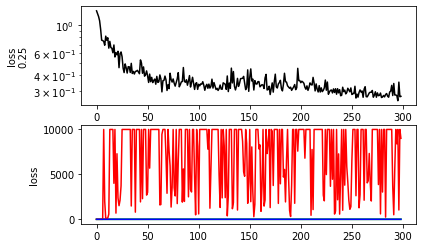

In [65]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:07,  1.60it/s]

Allocated: 0.03 GB  Reserved: 1.01 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6274 | Iter: 0.6263 | fit: 0.0832 | reg: 0.0823 | save: 0.0000) | autograd: 0.4586]


 17%|█▋        | 51/300 [00:35<07:25,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.5581 | lr: 0.0001 | n_subsample: 378] 
[Total time : 35.1488 | Iter: 30.6600 | fit: 0.0877 | reg: 0.0798 | save: 3.8600) | autograd: 0.4628]


 34%|███▎      | 101/300 [01:11<06:15,  1.89s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.4963 | lr: 0.0001 | n_subsample: 476] 
[Total time : 71.0976 | Iter: 31.8908 | fit: 0.0819 | reg: 0.0695 | save: 4.0568) | autograd: 0.4971]


 50%|█████     | 151/300 [01:49<04:39,  1.87s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.5125 | lr: 0.0001 | n_subsample: 600] 
[Total time : 109.5515 | Iter: 34.5990 | fit: 0.0873 | reg: 0.1097 | save: 3.8513) | autograd: 0.5431]


 67%|██████▋   | 201/300 [02:29<03:04,  1.86s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3814 | lr: 0.0001 | n_subsample: 756] 
[Total time : 149.2541 | Iter: 35.9197 | fit: 0.1049 | reg: 0.0836 | save: 3.7813) | autograd: 0.5521]


 84%|████████▎ | 251/300 [03:09<01:32,  1.88s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3118 | lr: 0.0001 | n_subsample: 953] 
[Total time : 189.5597 | Iter: 36.4566 | fit: 0.1177 | reg: 0.0937 | save: 3.8477) | autograd: 0.5663]


100%|██████████| 300/300 [03:49<00:00,  1.31it/s]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3109 | lr: 0.0001 | n_subsample: 953] 
[Total time : 229.2548 | Iter: 36.0819 | fit: 0.1037 | reg: 0.0811 | save: 3.6115) | autograd: 0.5136]


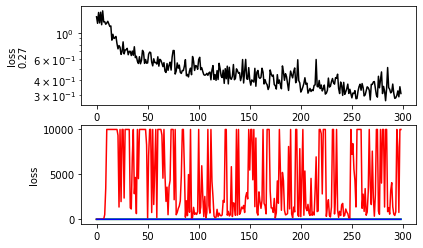

In [61]:
## TRAIN MF. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

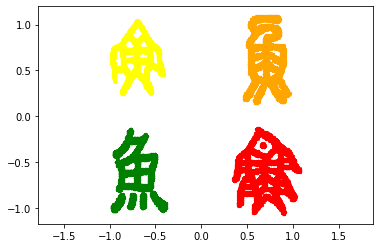

In [40]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, .6], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, -.6], rotate = 0),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, .6], rotate = 0),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, -.6], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:46,  1.76s/it]

Allocated: 0.04 GB  Reserved: 0.99 GB
[Loss: 1.4143 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7621 | Iter: 1.7605 | fit: 0.2533 | reg: 0.2061 | save: 0.0000) | autograd: 1.2984]


 17%|█▋        | 51/300 [01:44<18:24,  4.43s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.2327 | lr: 0.0001 | n_subsample: 378] 
[Total time : 104.6191 | Iter: 95.3438 | fit: 0.3409 | reg: 0.2402 | save: 7.5109) | autograd: 1.5946]


 34%|███▎      | 101/300 [03:47<14:42,  4.43s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.2681 | lr: 5e-05 | n_subsample: 476] 
[Total time : 227.1926 | Iter: 115.3376 | fit: 0.3866 | reg: 0.2328 | save: 7.2337) | autograd: 1.5654]


 50%|█████     | 151/300 [05:48<10:57,  4.41s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.4412 | lr: 2.5e-05 | n_subsample: 600] 
[Total time : 348.9586 | Iter: 114.5010 | fit: 0.3569 | reg: 0.2886 | save: 7.2634) | autograd: 1.6906]


 67%|██████▋   | 201/300 [07:51<07:33,  4.59s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.4429 | lr: 1.25e-05 | n_subsample: 756] 
[Total time : 471.0927 | Iter: 114.8102 | fit: 0.3559 | reg: 0.2746 | save: 7.3222) | autograd: 1.5808]


 84%|████████▎ | 251/300 [09:55<03:41,  4.51s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1771 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 595.1450 | Iter: 116.7083 | fit: 0.3815 | reg: 0.2988 | save: 7.3428) | autograd: 1.6202]


100%|██████████| 300/300 [11:56<00:00,  2.39s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1040 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 716.7629 | Iter: 114.2267 | fit: 0.3655 | reg: 0.3002 | save: 7.3898) | autograd: 1.7368]


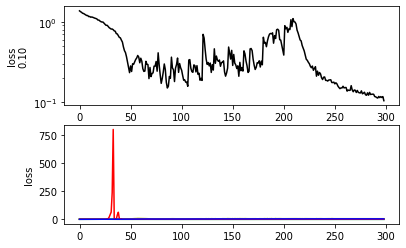

In [50]:
## TRAIN FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [51]:
# RENDER FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:16,  1.66s/it]

Allocated: 0.05 GB  Reserved: 0.99 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.6610 | Iter: 1.6594 | fit: 0.2434 | reg: 0.1921 | save: 0.0000) | autograd: 1.2209]


 17%|█▋        | 51/300 [01:45<17:52,  4.31s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.5209 | lr: 0.0001 | n_subsample: 378] 
[Total time : 105.2580 | Iter: 95.9364 | fit: 0.3437 | reg: 0.1897 | save: 7.6591) | autograd: 1.3182]


 34%|███▎      | 101/300 [03:49<15:07,  4.56s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1761 | lr: 0.0001 | n_subsample: 476] 
[Total time : 229.2284 | Iter: 116.5423 | fit: 0.3739 | reg: 0.2689 | save: 7.4254) | autograd: 1.7431]


 50%|█████     | 151/300 [05:55<11:28,  4.62s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1539 | lr: 0.0001 | n_subsample: 600] 
[Total time : 355.2608 | Iter: 118.4871 | fit: 0.3641 | reg: 0.2838 | save: 7.5440) | autograd: 1.6461]


 67%|██████▋   | 201/300 [08:04<07:44,  4.69s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.6395 | lr: 5e-05 | n_subsample: 756] 
[Total time : 484.4383 | Iter: 121.8992 | fit: 0.3713 | reg: 0.2942 | save: 7.2771) | autograd: 1.7430]


 84%|████████▎ | 251/300 [10:15<03:42,  4.54s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1229 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 615.0932 | Iter: 123.6742 | fit: 0.3708 | reg: 0.2979 | save: 6.9787) | autograd: 1.8265]


100%|██████████| 300/300 [12:23<00:00,  2.48s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.0903 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 743.0334 | Iter: 120.4441 | fit: 0.3626 | reg: 0.3111 | save: 7.4941) | autograd: 1.7717]


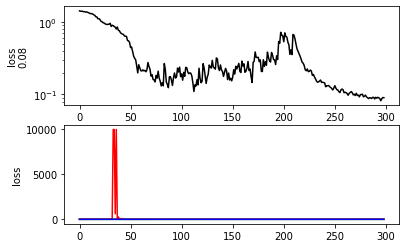

In [48]:
## TRAIN FISH1234. Jerk=.01, curl=1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_mincurl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<09:12,  1.85s/it]

Allocated: 0.05 GB  Reserved: 1.0 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.8488 | Iter: 1.8475 | fit: 0.2582 | reg: 0.2061 | save: 0.0000) | autograd: 1.3796]


 17%|█▋        | 51/300 [01:47<19:06,  4.60s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.2806 | lr: 0.0001 | n_subsample: 378] 
[Total time : 107.8846 | Iter: 98.4241 | fit: 0.3488 | reg: 0.2998 | save: 7.6107) | autograd: 1.6644]


 34%|███▎      | 101/300 [03:50<14:45,  4.45s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0799 | lr: 0.0001 | n_subsample: 476] 
[Total time : 230.3337 | Iter: 114.9874 | fit: 0.3471 | reg: 0.2256 | save: 7.4600) | autograd: 1.5489]


 50%|█████     | 151/300 [05:53<11:26,  4.61s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0714 | lr: 0.0001 | n_subsample: 600] 
[Total time : 353.3889 | Iter: 115.5960 | fit: 0.3541 | reg: 0.3052 | save: 7.4567) | autograd: 1.7868]


 67%|██████▋   | 201/300 [07:58<07:46,  4.72s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.1048 | lr: 5e-05 | n_subsample: 756] 
[Total time : 478.6190 | Iter: 117.4761 | fit: 0.3444 | reg: 0.2570 | save: 7.7523) | autograd: 1.6729]


 84%|████████▎ | 251/300 [10:05<03:47,  4.65s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0581 | lr: 5e-05 | n_subsample: 953] 
[Total time : 605.9871 | Iter: 119.4879 | fit: 0.3579 | reg: 0.2180 | save: 7.8780) | autograd: 1.5187]


100%|██████████| 300/300 [12:11<00:00,  2.44s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0424 | lr: 5e-05 | n_subsample: 953] 
[Total time : 731.2351 | Iter: 117.9243 | fit: 0.3798 | reg: 0.2288 | save: 7.3214) | autograd: 1.5924]


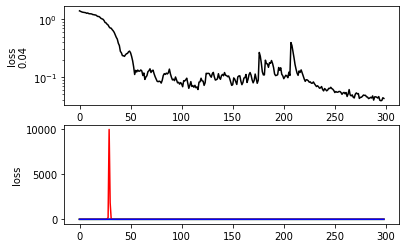

In [55]:
## TRAIN FISH1234. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [56]:
# RENDER FISH1234
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [ ]:
## GENERATE BUNCH OF IMAGES
im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')

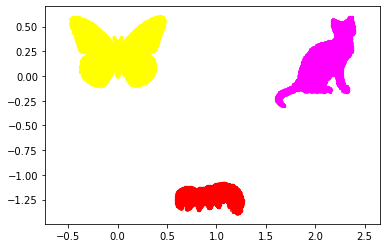

In [80]:
## GENERATE CYCLIC BUTTERFLY->CAT->CATERPILLAR
im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [1, -1.2]); 
d1a = im1.sample(n_inner, n_sil, center = [0, .13]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, .13]); 
d6 = im6.sample(n_inner, n_sil, center = [2, .15]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat6, col='magenta')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:37,  1.73s/it]

Allocated: 0.04 GB  Reserved: 0.95 GB
[Loss: 1.6068 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7319 | Iter: 1.7304 | fit: 0.2640 | reg: 0.1969 | save: 0.0000) | autograd: 1.2656]


 17%|█▋        | 51/300 [01:46<22:04,  5.32s/it]

Allocated: 0.04 GB  Reserved: 0.96 GB
[Loss: 0.2487 | lr: 0.0001 | n_subsample: 378] 
[Total time : 106.5122 | Iter: 94.8397 | fit: 0.3773 | reg: 0.2642 | save: 9.9394) | autograd: 1.6427]


 34%|███▎      | 101/300 [03:49<17:18,  5.22s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.1329 | lr: 0.0001 | n_subsample: 476] 
[Total time : 229.9612 | Iter: 113.7798 | fit: 0.3333 | reg: 0.2969 | save: 9.6678) | autograd: 1.6715]


 50%|█████     | 151/300 [05:55<12:54,  5.20s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.1238 | lr: 0.0001 | n_subsample: 600] 
[Total time : 355.2040 | Iter: 115.6385 | fit: 0.3516 | reg: 0.2930 | save: 9.6022) | autograd: 1.7191]


 67%|██████▋   | 201/300 [08:03<08:47,  5.33s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.0984 | lr: 5e-05 | n_subsample: 756] 
[Total time : 483.4506 | Iter: 118.4659 | fit: 0.3879 | reg: 0.3022 | save: 9.7797) | autograd: 1.7807]


 84%|████████▎ | 251/300 [10:16<04:21,  5.34s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.0869 | lr: 5e-05 | n_subsample: 953] 
[Total time : 616.1514 | Iter: 122.8978 | fit: 0.3786 | reg: 0.3317 | save: 9.8022) | autograd: 1.7436]


100%|██████████| 300/300 [12:44<00:00,  2.55s/it]

Allocated: 0.05 GB  Reserved: 0.97 GB
[Loss: 0.0785 | lr: 5e-05 | n_subsample: 953] 
[Total time : 764.3106 | Iter: 131.2372 | fit: 0.4627 | reg: 0.4124 | save: 16.9205) | autograd: 2.3690]


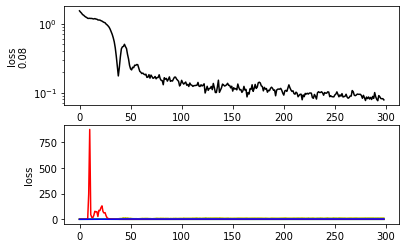

In [21]:
## TRAIN CYCLIC BUTTERFLY->CAT->CATERPILLAR. .1 radial, .01 jerk
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = len(keyframes)-1).to(device)
outfolder = "results/experiment_sinkhorn_scaling_radial/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [55]:
# RENDER CYCLIC BUTTERFLY->CAT->CATERPILLAR
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_sinkhorn_scaling_radial/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=20, cycle=True)